In [9]:
#Librairy 

import requests
import json
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import re

# 1. Twitch API data

The URL `https://wind-bow.glitch.me/twitch-api/channels/{CHANNEL_NAME}` is an API from twitch to get data from twitch channels.

Get the data from the following channels:

```
["ESL_SC2", "OgamingSC2", "cretetion", "freecodecamp", 
    "storbeck", "habathcx", "RobotCaleb", "noobs2ninjas",
    "ninja", "shroud", "Dakotaz", "esltv_cs", "pokimane", 
    "tsm_bjergsen", "boxbox", "wtcn", "a_seagull",
    "kinggothalion", "amazhs", "jahrein", "thenadeshot", 
    "sivhd", "kingrichard"]
```

To make into a dataframe that looks like this:

![](twitch.png)

In [10]:
channels = ["ESL_SC2", "OgamingSC2", "cretetion", "freecodecamp", 
    "storbeck", "habathcx", "RobotCaleb", "noobs2ninjas",
    "ninja", "shroud", "Dakotaz", "esltv_cs", "pokimane", 
    "tsm_bjergsen", "boxbox", "wtcn", "a_seagull",
    "kinggothalion", "amazhs", "jahrein", "thenadeshot", 
    "sivhd", "kingrichard"]

columns = ["id", "display_name", "status", "followers", "views"]

df = pd.DataFrame(columns = columns)




In [11]:
for c in range(len(channels)):
    r = requests.get(f"https://wind-bow.glitch.me/twitch-api/channels/{channels[c]}")
    content = json.loads(r.content)
    #print(content)
    if content["status"] == 200:
        df.loc[c] = [content["_id"], content["display_name"], content["status"], content["followers"], content                          ["views"]]

In [12]:
df.head(4)

,id,display_name,status,followers,views


# 2. App Store Reviews

The Apple app store has a `GET` API to get reviews on apps. The URL is:

```
https://itunes.apple.com/{COUNTRY_CODE}/rss/customerreviews/id={APP_ID_HERE}/page={PAGE_NUMBER}/sortby=mostrecent/json
```

Note that you need to provide:

- The country code (eg. `'us'`, `'gb'`, `'ca'`, `'au'`) 

- The app ID. This can be found in the web page for the app right after `id`. For instance, Candy Crush's US webpage is:

`https://apps.apple.com/us/app/candy-crush-saga/id553834731`

So here the ID would be `553834731`.

- The "Page Number". The request responds with multiple pages of data, but sends them one at a time. So you can cycle through the data pages for any app on any country.

### 2.1 English app reviews

Get all english reviews you can for Candy Crush, Tinder, the Facebook app and Twitter (you have to get them from all the english-speaking countries you can think of!).

### 2.2 Best version

For each app, get the version that is the best rated.

Make a visualization of the ratings per versions per app to show this.

### 2.3 Top words

Which word for each app is most common in the 5 star and in the 1-star review's titles?

Note: `df.title.str.get_dummies()` is your friend

Note: This might create a lot of data! Try to break down your analysis in chunks if it doesn't work.

In [13]:
#2.1 English app review - get english review for Candy Crush, Tinder, Facebook, and Twitter

apps = ['candycrush', 'tinder', 'twitter', 'facebook']
ids = [553834731, 547702041, 333903271, 284882215]


#took a list of country from wikipedia where english is an official language. 
countries = ["au", "us", "ca", "uk", "nz", "gh", "ng", "fj", "sg", "ie", "ke", "gd", "za", "ag", "bs", "bb", "bz",               "dm", "gy", "jm", "lr", "pg", "kn", "lc", "vc", "sl", "tt"]


In [51]:
                url = f'https://itunes.apple.com/{c}/rss/customerreviews/id={id}/page={pg}/sortby=mostrecent/json'
                r = requests.get(url)
                j = json.loads(r.content)

                j

pdate makes Facebook look like a copyrighted website.. in other words it doesn’t look original. So disappointed! Please revert back to the original version it had before.\nThank you!',
     'attributes': {'type': 'text'}},
    'link': {'attributes': {'rel': 'related',
      'href': 'https://itunes.apple.com/tt/review?id=284882215&type=Purple%20Software'}},
    'im:voteSum': {'label': '1'},
    'im:contentType': {'attributes': {'term': 'Application',
      'label': 'Application'}},
    'im:voteCount': {'label': '1'}},
   {'author': {'uri': {'label': 'https://itunes.apple.com/tt/reviews/id372683730'},
     'name': {'label': 'QXio'},
     'label': ''},
    'im:version': {'label': '246.0'},
    'im:rating': {'label': '3'},
    'id': {'label': '5120344840'},
    'title': {'label': 'Constant crashing since update'},
    'content': {'label': 'My app keeps crashing since your last update 😔 I have lots of space and clear the cache often. Don’t know why that’s happening. Can someone give insight

In [53]:
df = pd.DataFrame()

for id in ids: 
    for c in countries:
        pg = 1

        r.status_code = 200
        while r.status_code == 200:
            try:
                url = f'https://itunes.apple.com/{c}/rss/customerreviews/id={id}/page={pg}/sortby=mostrecent/json'
                r = requests.get(url)
                j = json.loads(r.content)
                reviews = {}
                reviews['version'] = [ e['im:version']['label'] for e in j['feed']['entry'] ]
                reviews['rating'] = [ e['im:rating']['label'] for e in j['feed']['entry'] ]
                reviews['title'] = [ e['title']['label'] for e in j['feed']['entry'] ]
                reviews['comment'] = [ e['content']['label'] for e in j['feed']['entry'] ]
                reviews['country'] = [c for _ in range(0,len(reviews['version']))]
                reviews['app'] = [id for _ in range(0,len(reviews['version']))]
                pg += 1
            except:
                r.status_code = 999
            
            df = pd.concat([df, pd.DataFrame.from_dict(reviews)])

df['app'] = df['app'].replace(ids,apps)

df = df[['app', 'country', 'version', 'rating', 'title', 'comment']]


In [54]:
df.head(10)
#df.info()

,app,country,version,rating,title,comment
0,candycrush,au,1.196.1.1,1,"Starting over, what???","I was doing so well, then I came to a black sc..."
1,candycrush,au,1.196.1.1,1,Boring,"Repetitive game, which after a short time beco..."
2,candycrush,au,1.196.1.1,4,Brilliant App,"I love it, it’s multiplayer I’m not sure it sh..."
3,candycrush,au,1.196.1.1,5,Please can you I be pay with my coins,I wanna know if I can be bay with my coins
4,candycrush,au,1.196.1.1,1,Candy Crush Saga,Once I go through the beginning before touchin...
5,candycrush,au,1.196.1.1,1,no booster glitch,sometimes when we win the team prize it just d...
6,candycrush,au,1.196.1.1,1,Log in problem,Can’t log in today after update ????????
7,candycrush,au,1.196.1.1,1,Impossible,"Move on to another game, this used to be a rel..."
8,candycrush,au,1.196.1.1,1,Latest update,The latest update freezers at the loading page
9,candycrush,au,1.196.0.1,2,What the heck? No gold bars for episode races?,I enjoy Candy Crush - great stress reliever - ...


In [41]:
#2.2 For each app, get the version that is the best rated. add viz 

#Let's keep the version with atleast 25 reviews 


df.rating = df.rating.astype(int)

df_25 = df.groupby(by=['app','version']).filter(lambda x : len(x)>25)
df_25 = df_25.groupby(by=['app','version']).rating.mean().sort_values(ascending=False)


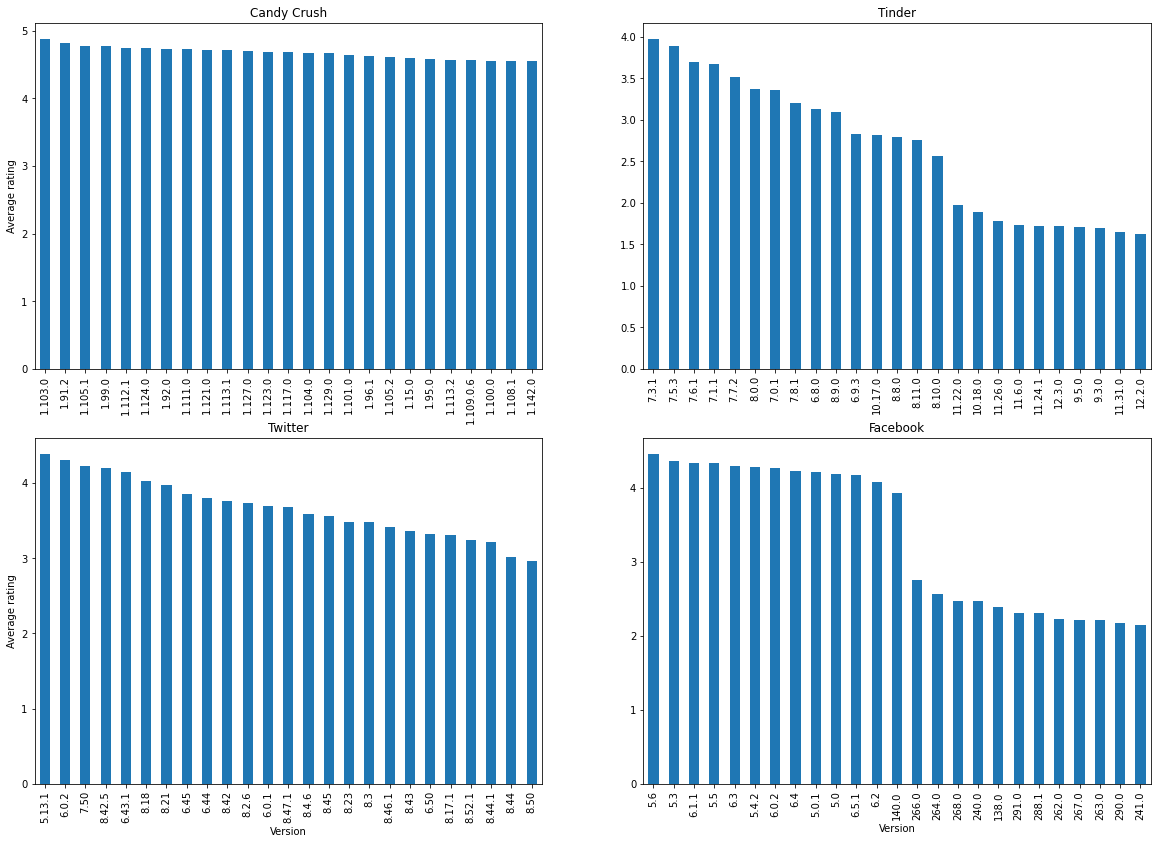

In [44]:
#visualize the data 

fig, axes = plt.subplots(2, 2, figsize=(20,14))

df_25['candycrush'][:25].plot.bar(ax=axes[0,0]);
axes[0,0].set_title('Candy Crush');
axes[0,0].set_ylabel("Average rating");
axes[0,0].xaxis.label.set_visible(False);
df_25['tinder'][:25].plot.bar(ax=axes[0,1]);
axes[0,1].set_title('Tinder');
axes[0,1].xaxis.label.set_visible(False);
df_25['twitter'][:25].plot.bar(ax=axes[1,0]);
axes[1,0].set_title('Twitter');
axes[1,0].set_ylabel("Average rating");
axes[1,0].set_xlabel("Version");
df_25['facebook'][:25].plot.bar(ax=axes[1,1]);
axes[1,1].set_title('Facebook');
axes[1,1].set_xlabel("Version");

In [69]:
df['title'] = df['title'].str.lower()
df_1 = df.loc[df['rating'] == '1']
df_5 = df.loc[df['rating'] == "5"]
df5 = df_5.title.str.get_dummies()
df1 = df_1.title.str.get_dummies()
df_1

,app,country,version,rating,title,comment
0,candycrush,au,1.196.1.1,1,"starting over, what???","I was doing so well, then I came to a black sc..."
1,candycrush,au,1.196.1.1,1,boring,"Repetitive game, which after a short time beco..."
4,candycrush,au,1.196.1.1,1,candy crush saga,Once I go through the beginning before touchin...
5,candycrush,au,1.196.1.1,1,no booster glitch,sometimes when we win the team prize it just d...
6,candycrush,au,1.196.1.1,1,log in problem,Can’t log in today after update ????????
...,...,...,...,...,...,...
32,facebook,tt,5.1,1,new update,This new update does not work. Keep getting a ...
38,facebook,tt,5.0.1,1,help,How do I get this app on my 3gs phone
43,facebook,tt,5.0.1,1,new fb app is not an improvement over the last...,App is not an improvement.
5,facebook,tt,5.0.1,1,very very poor,Poor poor


In [70]:
df1.sum(axis = 0).idxmax(), df1.sum(axis = 0).max()

('censorship', 152)

In [71]:

df5.sum(axis = 0).idxmax(), df5.sum(axis = 0).max()

('candy crush', 277)

# 3 (STRETCH) IMDB scraping

IMDB has structured web pages. We can exploit this to scrape movie data.

Usinf the following URL:

`https://www.imdb.com/search/title/?groups=top_1000&start={PAGE_NUMBER}&ref_=adv_nxt`

With the following headers in your `GET` request: `{"Accept-Language": "en-US,en;q=0.5"}`

You can generate a dataframe like this one by cycling over the page numbers in the URL requested:

![](IMDB.png)

Note that the following  page attribues will be of interest:

- `div` with a class of `lister-item mode-advanced`

- Various `span` objects within that `div` like `lister-item-year` and `runtime` and `metascore`